In [1]:
import torch 
import numpy as np
import pandas as pd
import skimage 
import src

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

## TO DOs
* ~~import CelebA .csv~~
* ~~compute percentage of men and women for any other categories~~
    * ~~visualisation~~
* ~~compute distribution of our ranking score for every category~~
    * ~~visualisation~~
* ~~print the top 36 images~~
* ~~import features space after TSNE~~
    * ~~print such a space with points colored with a heatmap according with the ranking score~~
* import the result of partial clustering 
    * print the centroid for every cluster

In [4]:
# paths 
celebA_csv = "../data/celeba/list_attr_celeba.csv"
results_folder = "../results"
models_folder = results_folder + "/Results_CelebA_ResNet18/input_dim_1000" +\
                "/init_trunc_inv_sqrt/layers_3/neuron_1024/" +\
                "lambda_cvx_0.1_mean_0.0/" +\
                "optim_Adamlr_0.001betas_0.5_0.99/gen_16/batch_25/" +\
                "trial_1_last_inp_qudr/storing_models"

In [5]:
# other inputs
# final epoch of ICNN training
final_epoch = 14

# GPU acceleration
cuda = torch.cuda.is_available()
mps = torch.backends.mps.is_available()

In [6]:
# import celebA data
df = pd.read_csv(celebA_csv)

df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [7]:
# import feature extractor
features = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/simone/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%


We compute the percentage of men and women for each attribute in CelebA.

In [8]:
# for every attribute, compute the percentage of men and women with that attribute
n_male = len(df[df["Male"] == 1])
n_female = len(df[df["Male"] == -1])

bias = dict()

for col in df.columns:
    n_male_col = len(df[(df["Male"] == 1) & (df[col] == 1)])
    n_female_col = len(df[(df["Male"] == -1) & (df[col] == 1)])
    
    bias[col] = {"Male" : n_male_col/n_male,
                 "Female" : n_female_col/n_female}

bias.pop("image_id")
bias.pop("Male")

{'Male': 1.0, 'Female': 0.0}

In [9]:
# function that saves barplots
def make_barplot(path, column, values):
    plt.bar(["Male", "Female"], [val for key, val in values.items()], color = ["mediumseagreen", "mediumpurple"])
    plt.title(column)
    plt.savefig(path + "/{}.jpeg".format(column))

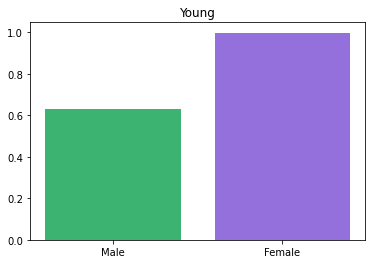

In [10]:
# save the barplots
for col, values in bias.items():
    make_barplot(results_folder + "/barplots_celeba", col, values)

We compute the distribution of the ranking score for men and women with respect to each attribute.

In [11]:
# foo colums, to be replaced with the actual ranking score 
df["foo"] = np.random.normal(size=len(df))

In [12]:
def make_histograms(path, df, col, score, gender = "Male"):
    plt.hist(df[df[col] == 1][score])
    plt.title(gender + " " + col)
    #plt.savefig(path + "/{}.jpeg".format(col))
    plt.show()

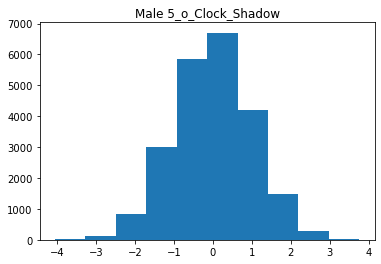

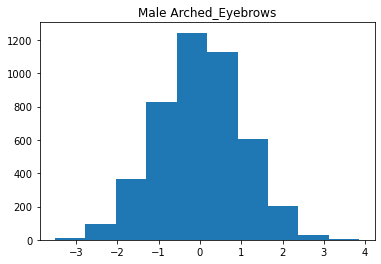

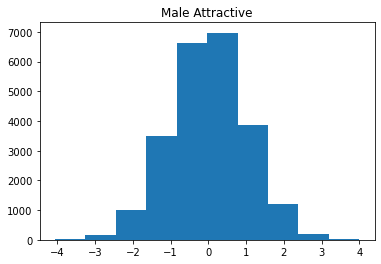

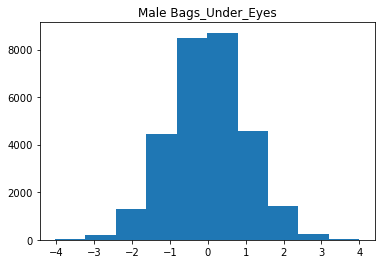

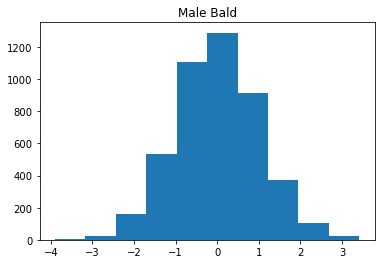

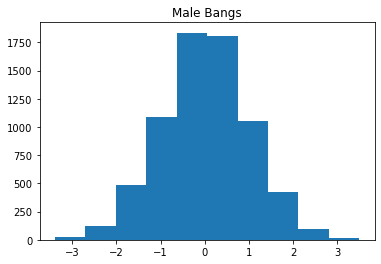

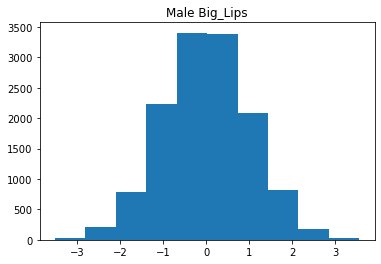

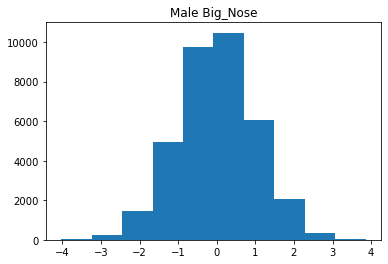

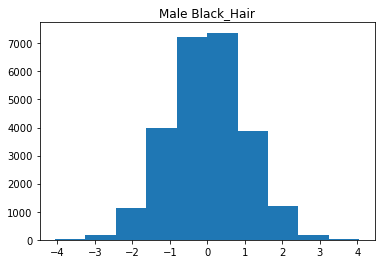

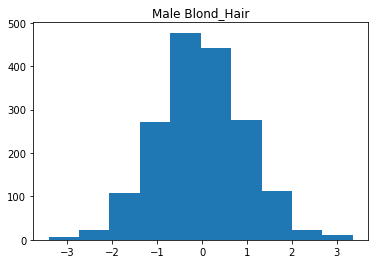

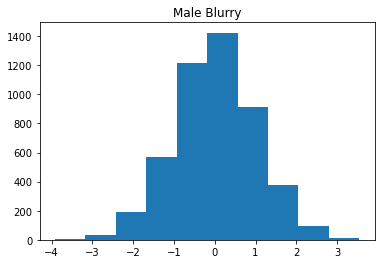

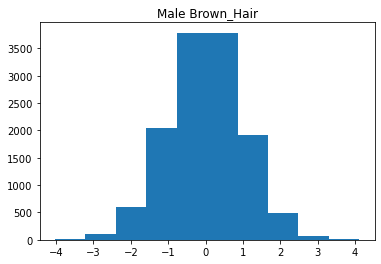

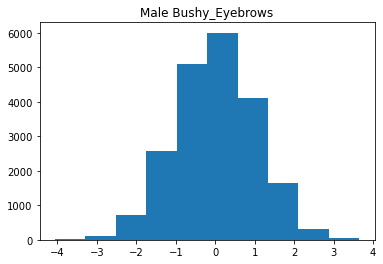

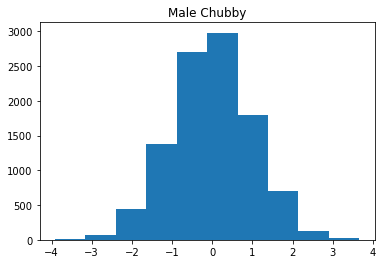

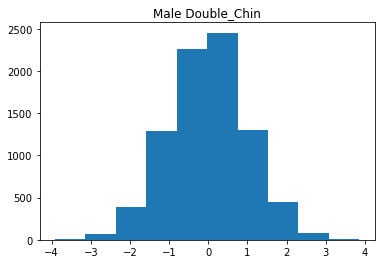

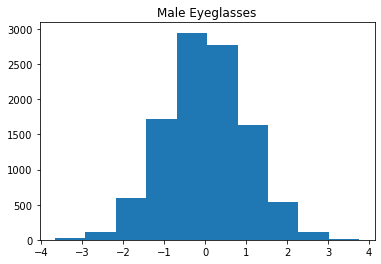

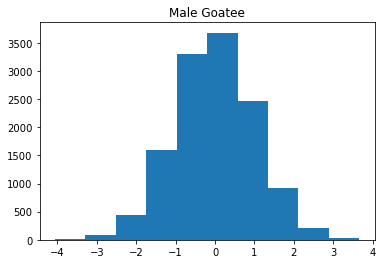

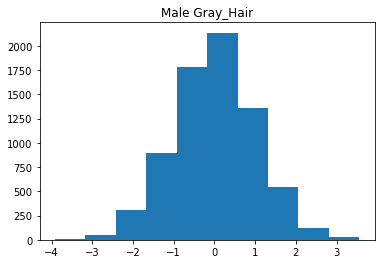

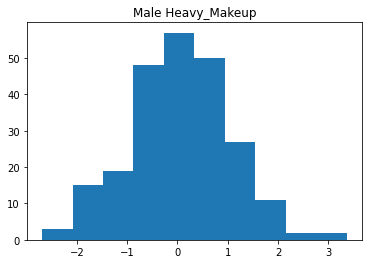

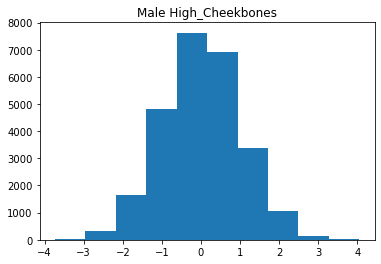

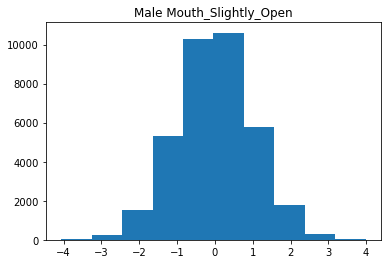

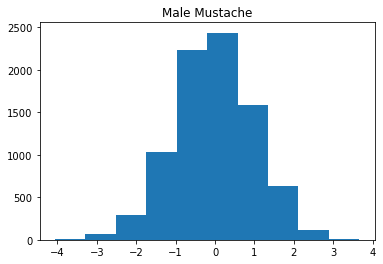

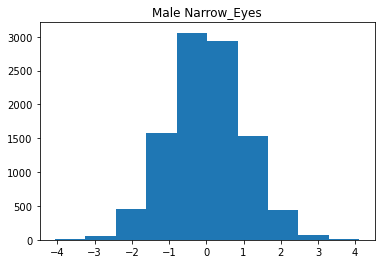

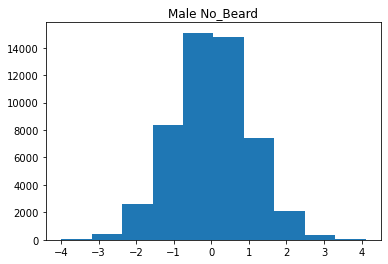

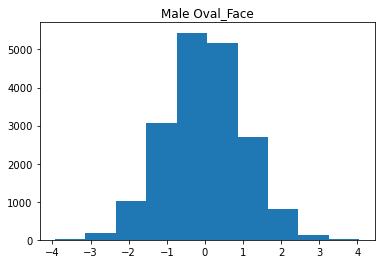

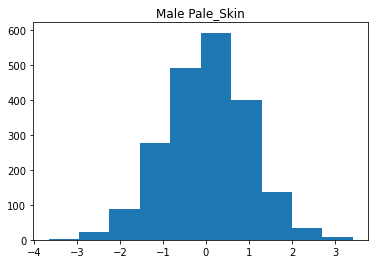

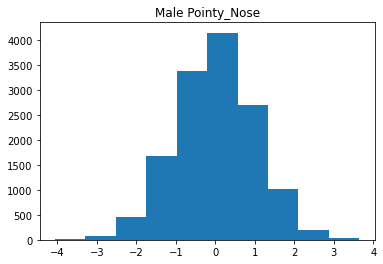

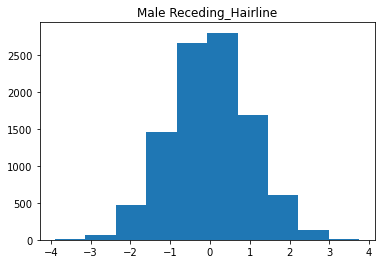

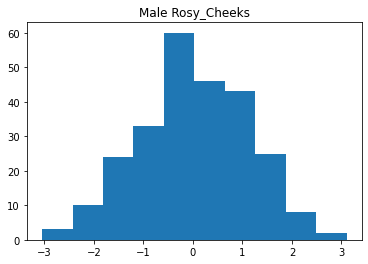

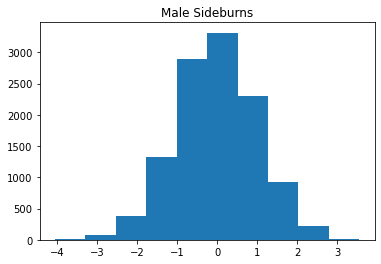

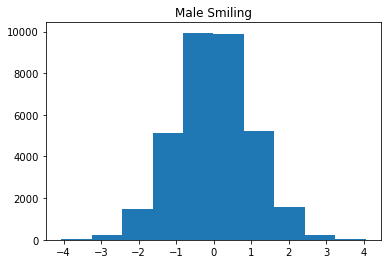

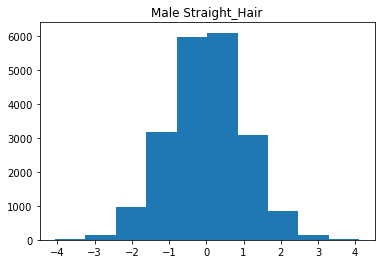

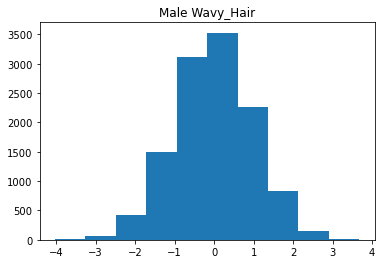

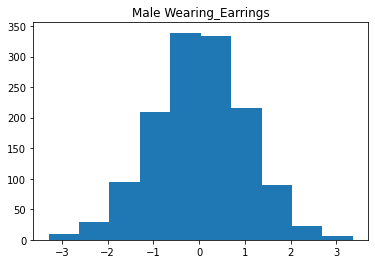

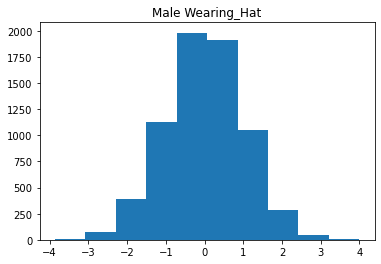

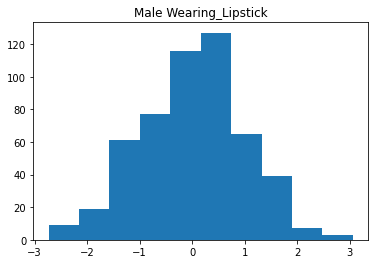

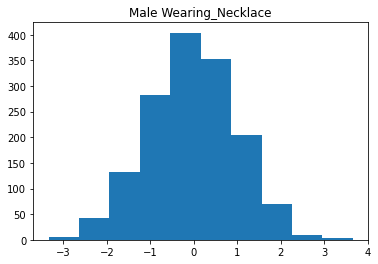

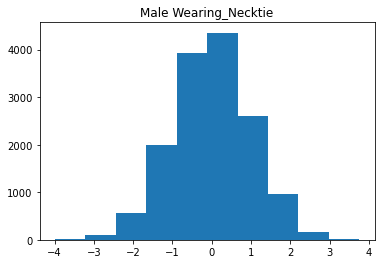

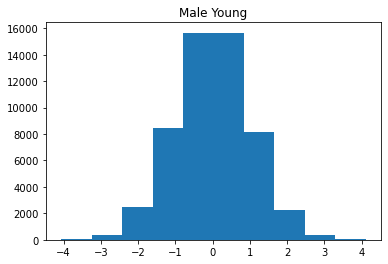

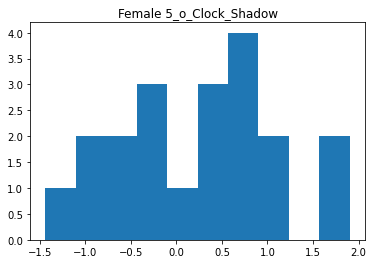

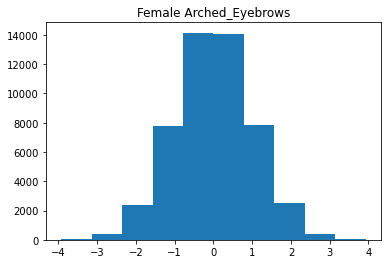

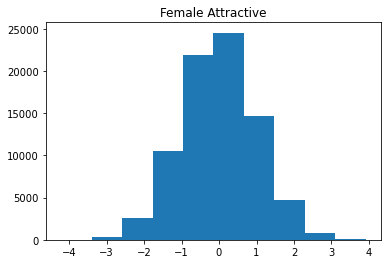

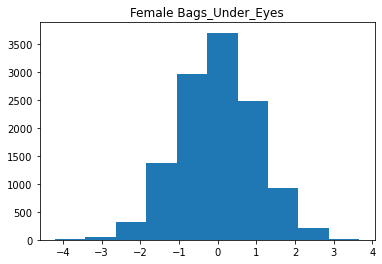

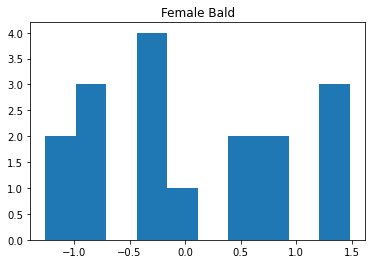

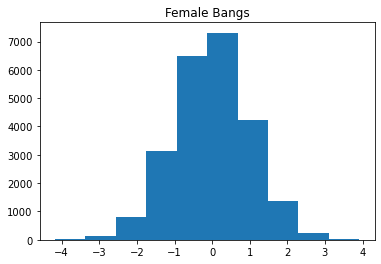

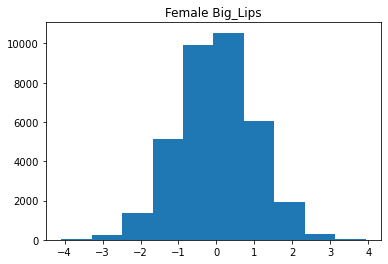

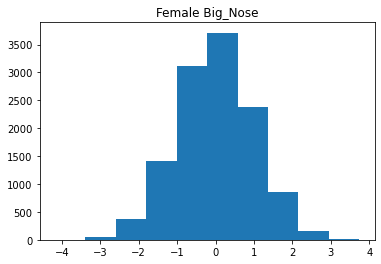

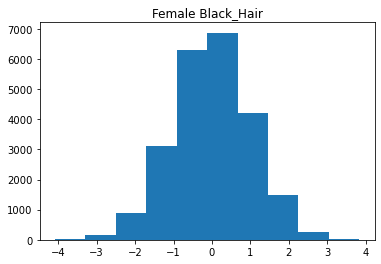

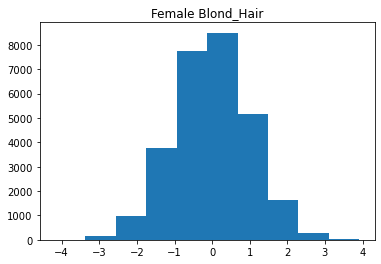

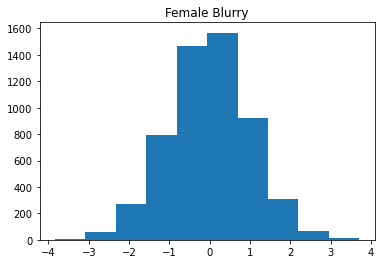

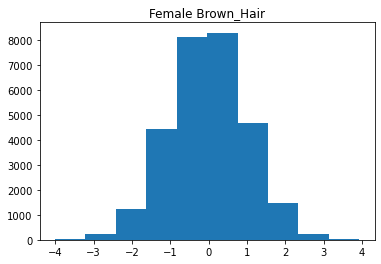

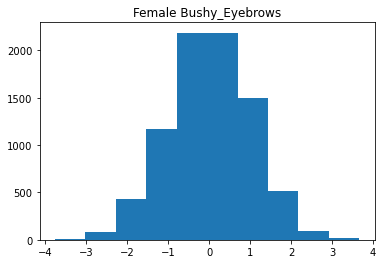

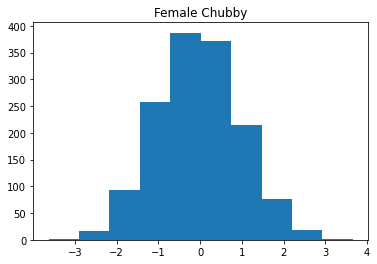

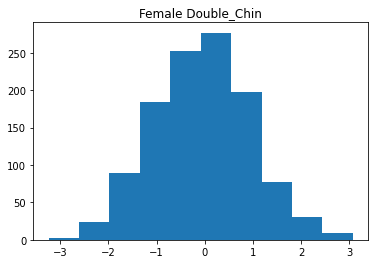

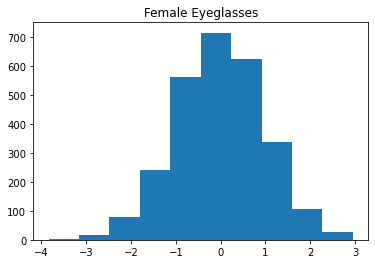

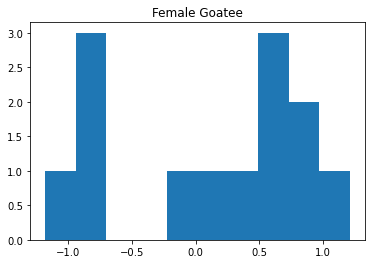

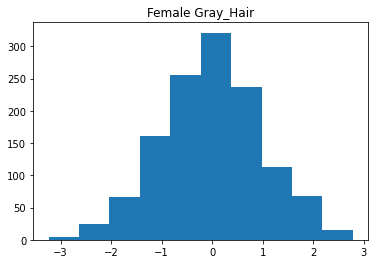

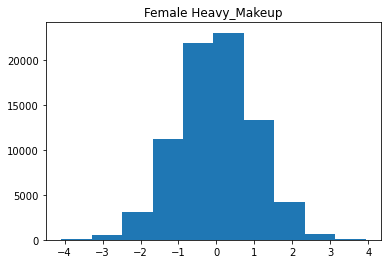

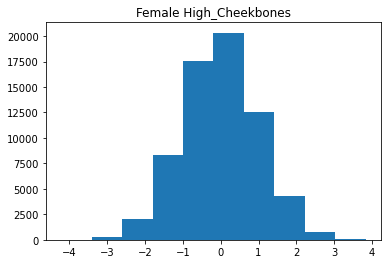

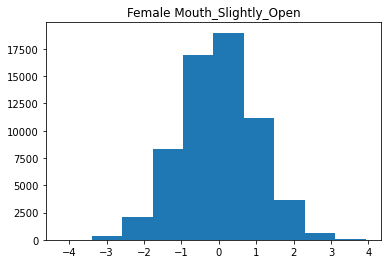

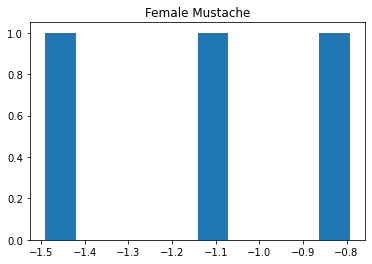

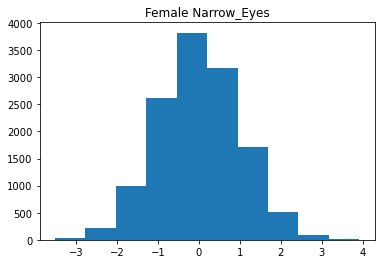

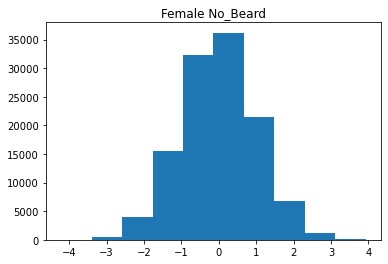

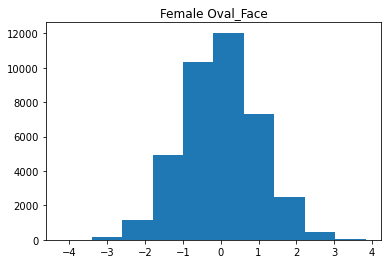

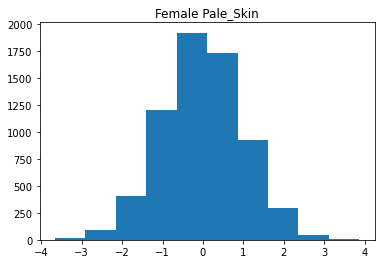

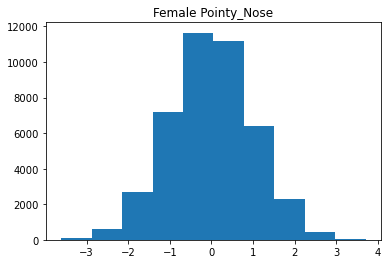

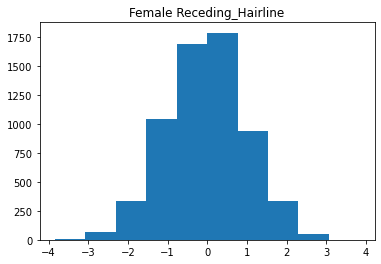

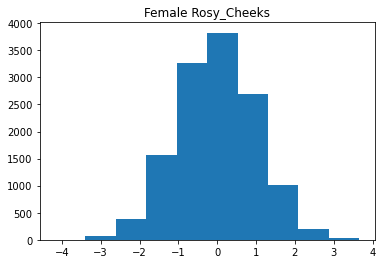

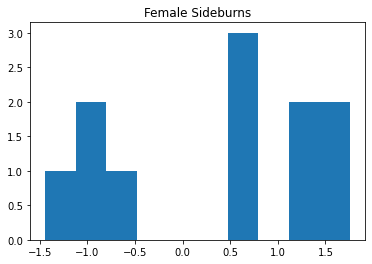

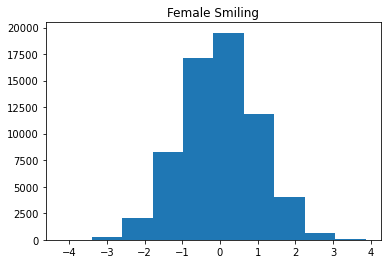

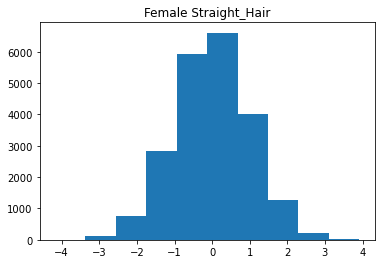

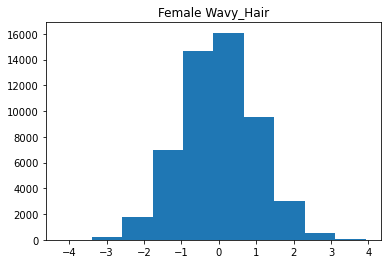

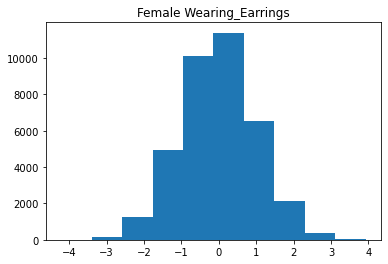

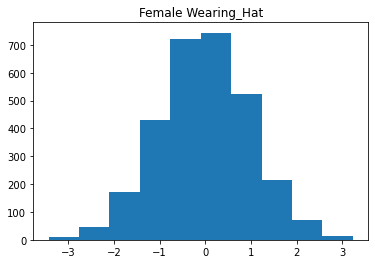

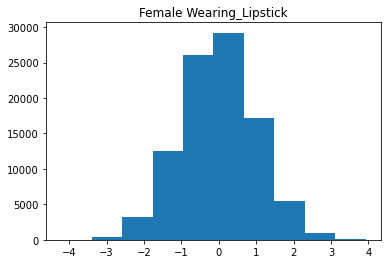

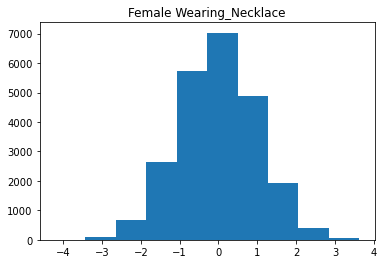

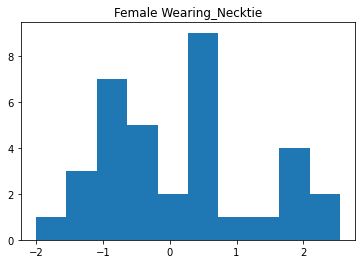

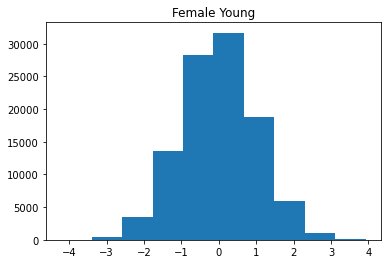

In [13]:
for male in [1,-1]:
    df_gender = df[df["Male"] == male]
    if male == 1:
        gender = "Male"
    else:
        gender = "Female"
    for col in bias.keys():
        make_histograms(results_folder + "/histograms_celeba", df_gender, col, "foo", gender)

We plot the top 36 images according to the ranking. 

In [14]:
def save_images_as_grid(path, array_img_vectors):

    array_img_vectors = torch.from_numpy(array_img_vectors)\
        .float().permute(0, 3, 1, 2)
    grid = make_grid(array_img_vectors, nrow=6, normalize=True)*255
    ndarr = grid.to('cpu', torch.uint8).numpy().T
    im = Image.fromarray(ndarr.transpose(1, 0, 2))

    #im.save(path)
    display(im)

In [15]:
img_ids = df.sort_values(by="foo", ascending=False)["image_id"][:36]
array_img_vectors = np.array(
    [skimage.io.imread("../data/celeba/Img_folder/Img/" + file)
     for file in img_ids])

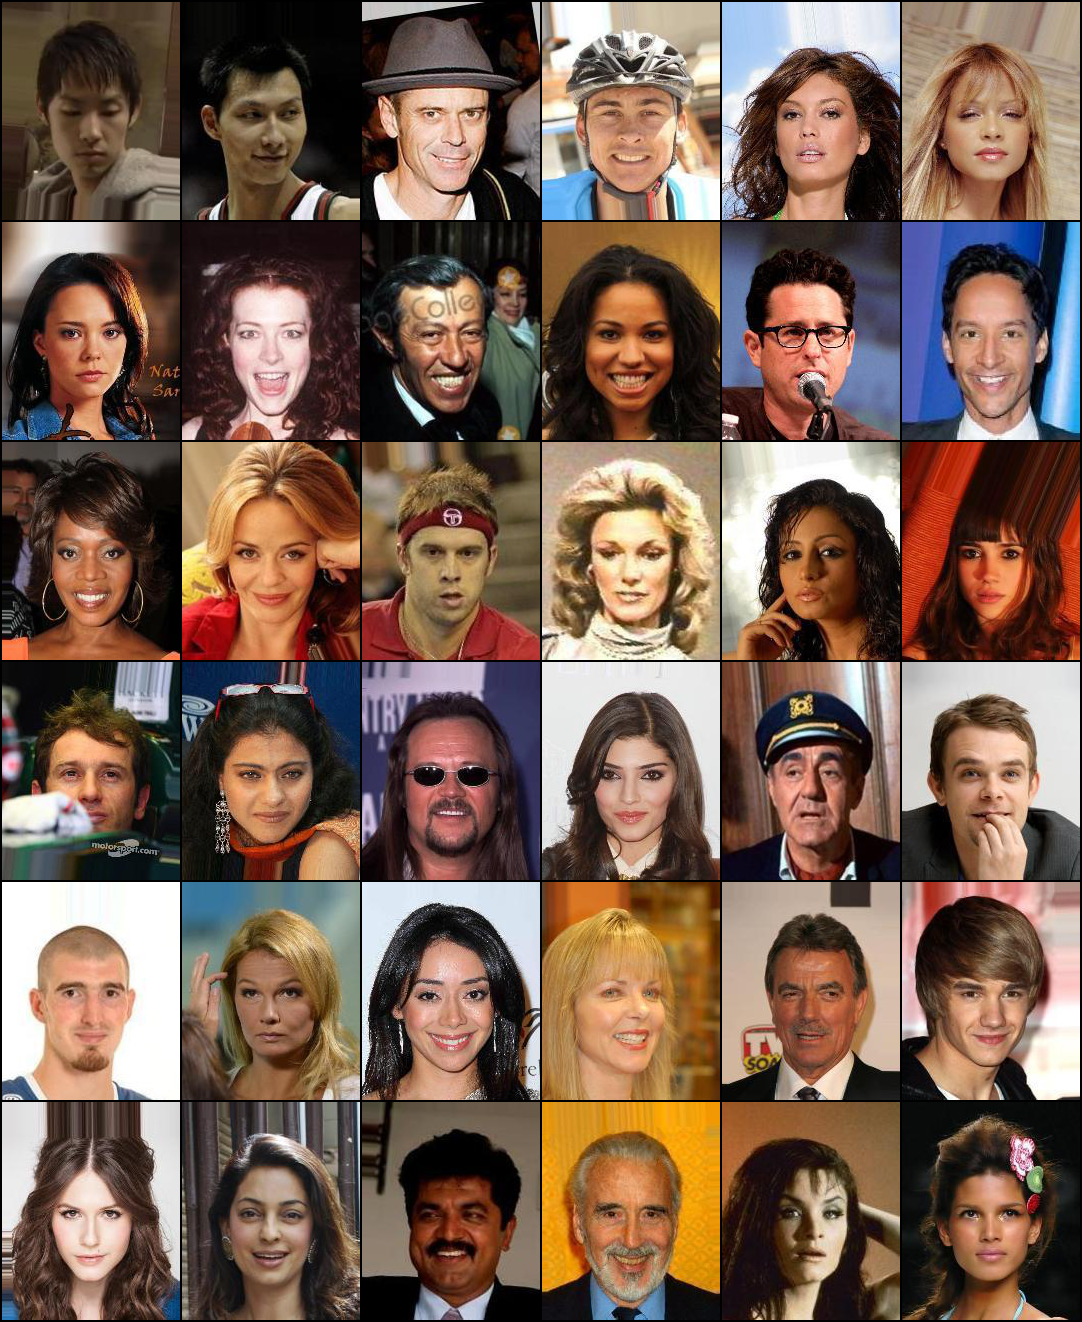

In [16]:
save_images_as_grid("", array_img_vectors)

We open the numpy array of our feature space

In [17]:
def open_array():
    pass

In [18]:
# space = open_array()
space = np.random.randn(160, 512)

We plot the TSNE representation of our space. We distinguisce points sampled from the two distributions. The features extracted from female subjects are colered according to our ranking score.

In [19]:
def plot_tsne(path, array1, array2, scores):
    
    fig, ax = plt.subplots()
    
    sc1 = plt.scatter(array1[:,0], array1[:,1], marker="^", c="gray")
    sc2 = plt.scatter(array2[:,0], array2[:,1], marker="o",
                c=scores, cmap="plasma_r")
    plt.title("TSNE representation of the feature space")
    
    axcb = fig.colorbar(sc2)
    axcb.set_label('Ranking score')
    
    # plt.savefig(path + "/Tsne_plot.jpeg")
    plt.show()

In [20]:
sample_female = df[df["Male"] == -1].sample(30)
sample_female_score = sample_female["foo"].values
# sample_female_array = space[sample_female.index]
sample_female_array = space[:30]

sample_male = df[df["Male"] == 1].sample(30)
# sample_male_array = space[sample_male.index]
sample_male_array = space[-30:]
tsne = TSNE()

transformed_space = tsne.fit_transform(space)

del space

/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


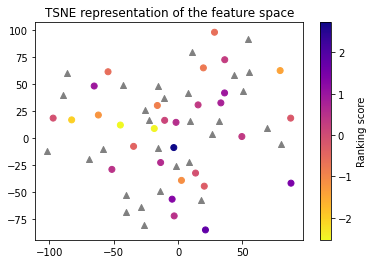

In [21]:
plot_tsne("",
          transformed_space[:30],
          transformed_space[-30:],
          sample_female_score)

We cluster the features of the top 10% images according to the ranking and show the images that are the closest to the centroids. 

In [28]:
space = np.random.randn(len(df), 512)
nintieth_quatile = df.foo.quantile(.9)

indeces = df[df["foo"] >= nintieth_quatile].index

to_cluster = space[indeces]

In [30]:
kmeans = KMeans()

kmeans.fit(to_cluster)

KMeans()

In [32]:
kmeans.cluster_centers_

array([[ 1.12358172e-02,  2.89628457e-02,  6.44828901e-02, ...,
         3.40785977e-02, -2.71094812e-02, -4.84924209e-02],
       [ 1.95501048e-01, -1.66615175e-01, -5.00411687e-02, ...,
         1.04583858e-01,  2.10235886e-03,  1.96242485e-02],
       [ 1.19035712e-01, -4.64266749e-02,  2.20104551e-02, ...,
        -5.12065097e-02,  1.24427010e-01, -6.28868208e-05],
       ...,
       [-1.10350181e-01,  5.42604313e-02, -5.63997806e-02, ...,
        -5.50104198e-02,  7.53696351e-02, -9.24122623e-02],
       [ 7.10308503e-02,  1.22853856e-01, -3.83208430e-02, ...,
         1.10364019e-01, -3.68197919e-02,  1.12754585e-01],
       [-1.48655260e-01,  1.96357512e-01, -1.87515433e-02, ...,
         3.20567922e-02, -6.98847765e-03, -1.16063523e-01]])

Centroid of cluster 0


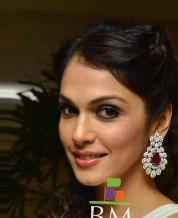

Centroid of cluster 1


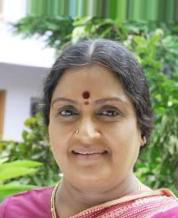

Centroid of cluster 2


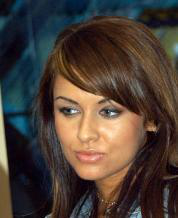

Centroid of cluster 3


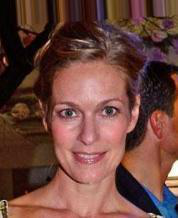

Centroid of cluster 4


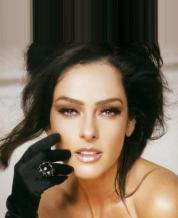

Centroid of cluster 5


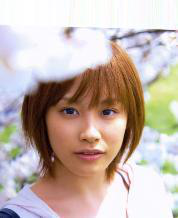

Centroid of cluster 6


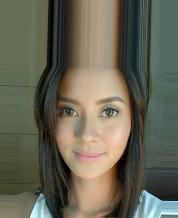

Centroid of cluster 7


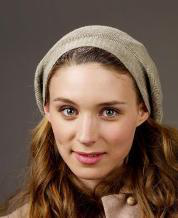

In [66]:
for i in set(kmeans.labels_):
    # select elements of the cluster
    elements = to_cluster[kmeans.labels_ == i]
    
    centroid = kmeans.cluster_centers_[i]
 
    minimum = elements[np.linalg.norm(elements - centroid, axis = 1).argmin()]

    to_print = np.linalg.norm(space - minimum, axis = 1).argmin()
    
    file = df.loc[to_print, "image_id"]
    image = skimage.io.imread("../data/celeba/Img_folder/Img/" + file)
    
    im = Image.fromarray(image)

    #im.save(path)
    print("Centroid of cluster {}".format(i))
    display(im)
    